# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from statistics import mean

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

#We can define common uncertainties and outcomes for each model:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]


#Define the Python model
py_model = Model('Python', function=pred_prey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes


nr_experiments = 100

#Using Latin Hypercube sampling
experiments, outcomes = perform_experiments(py_model, nr_experiments, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [3]:
experiments.head()

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001707,0.003869,0.063807,0.016237,0,None,Python
1,0.002377,0.001985,0.049854,0.030489,1,None,Python
2,0.002487,0.001556,0.045453,0.027952,2,None,Python
3,0.000827,0.002988,0.076633,0.033482,3,None,Python
4,0.001243,0.003282,0.067999,0.022875,4,None,Python


In [4]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001707,0.003869,0.063807,0.016237,0,None,Python
1,0.002377,0.001985,0.049854,0.030489,1,None,Python
2,0.002487,0.001556,0.045453,0.027952,2,None,Python
3,0.000827,0.002988,0.076633,0.033482,3,None,Python
4,0.001243,0.003282,0.067999,0.022875,4,None,Python
...,...,...,...,...,...,...,...
95,0.001403,0.002509,0.043210,0.023640,95,None,Python
96,0.001667,0.003815,0.046314,0.027208,96,None,Python
97,0.001035,0.002458,0.057294,0.017521,97,None,Python
98,0.001174,0.001719,0.050991,0.015768,98,None,Python


# Part 1

### Regression

In [5]:
# calculate final outcomes
final_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    final_outcomes_prey.append((outcomes['prey'][i][-1]))

In [6]:
# calculate mean values of prey over time 
mean_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean((outcomes['prey'][i])))

In [7]:
# calculate standard deviation over time
std_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(((outcomes['prey'][i]))))

In [8]:
# Fit a linear regression model for the final outcomes
x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_final = sm.OLS(final_outcomes_prey, x)
res_fin = reg_mod_final.fit()


print(res_fin.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.719
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              61.37
Date:                Sun, 09 May 2021   Prob (F-statistic):                    1.26e-25
Time:                        19:50:33   Log-Likelihood:                         -431.40
No. Observations:                 100   AIC:                                      870.8
Df Residuals:                      96   BIC:                                      881.2
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [9]:
res_fin.fittedvalues

0     18.412198
1     23.540908
2     24.179902
3     33.381141
4     25.538184
        ...    
95    12.701076
96     3.859427
97    24.346682
98    26.154801
99     3.867336
Length: 100, dtype: float64

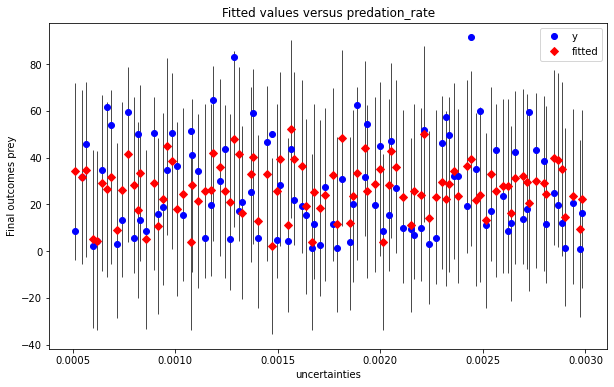

In [10]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_fin, 0, ax=ax)
fig.set_size_inches(10, 6, forward=True)
ax.set_ylabel("Final outcomes prey")
ax.set_xlabel("uncertainties")

plt.show()

In [11]:
predation=[]
for i in range(len(experiments)):
    predation.append(experiments.iloc[i,0])
predator_efficiency=[]
for i in range(len(experiments)):
    predator_efficiency.append(experiments.iloc[i,1])
predator_loss_rate=[]
for i in range(len(experiments)):
    predator_loss_rate.append(experiments.iloc[i,2])
prey_birth=[]
for i in range(len(experiments)):
    prey_birth.append(experiments.iloc[i,3])

In [12]:
ys = res_fin.fittedvalues.values
predation, ys = zip(*sorted(zip(predation, ys)))
predator_efficiency, ys =zip(*sorted(zip(predator_efficiency, ys)))
predator_loss_rate, ys =zip(*sorted(zip(predator_loss_rate, ys)))
prey_birth, ys =zip(*sorted(zip(prey_birth, ys)))

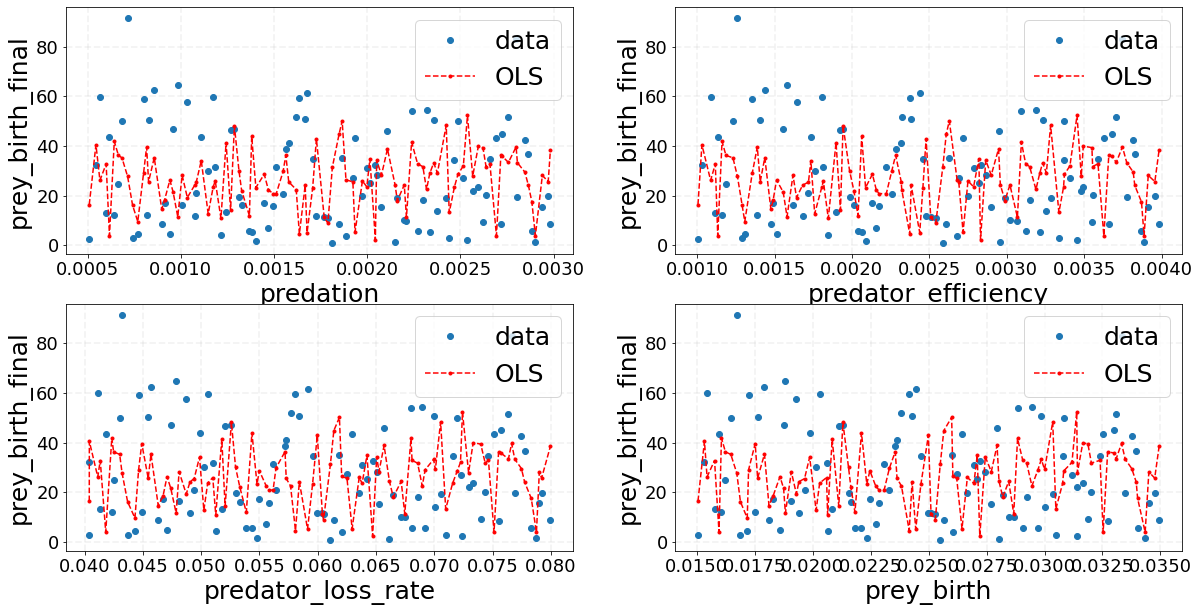

In [13]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(predation,final_outcomes_prey, 'o', label="data")
ax[0,0].tick_params(labelsize=18)
ax[0,0].plot(predation, ys, 'r--.', label="OLS")
ax[0,0].set_xlabel('predation',fontsize=25)
ax[0,0].set_ylabel('prey_birth_final',fontsize=25)
ax[0,0].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[0,0].legend(fontsize=25,loc="upper right");

ax[0,1].plot(predator_efficiency,final_outcomes_prey, 'o', label="data")
ax[0,1].tick_params(labelsize=18)
ax[0,1].plot(predator_efficiency, ys, 'r--.', label="OLS")
ax[0,1].set_xlabel('predator_efficiency',fontsize=25)
ax[0,1].set_ylabel('prey_birth_final',fontsize=25)
ax[0,1].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[0,1].legend(fontsize=25,loc="upper right");

ax[1,0].plot(predator_loss_rate,final_outcomes_prey, 'o', label="data")
ax[1,0].tick_params(labelsize=18)
ax[1,0].plot(predator_loss_rate, ys, 'r--.', label="OLS")
ax[1,0].set_xlabel('predator_loss_rate',fontsize=25)
ax[1,0].set_ylabel('prey_birth_final',fontsize=25)
ax[1,0].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[1,0].legend(fontsize=25,loc="upper right");

ax[1,1].plot(prey_birth,final_outcomes_prey, 'o', label="data")
ax[1,1].tick_params(labelsize=18)
ax[1,1].plot(prey_birth, ys, 'r--.', label="OLS")
ax[1,1].set_xlabel('prey_birth',fontsize=25)
ax[1,1].set_ylabel('prey_birth_final',fontsize=25)
ax[1,1].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[1,1].legend(fontsize=25,loc="upper right");

# Fit a linear regression model for the mean values over time

In [14]:
x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_mean = sm.OLS(mean_outcomes_prey, x)
res_mean = reg_mod_mean.fit()


print(res_mean.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              485.0
Date:                Sun, 09 May 2021   Prob (F-statistic):                    9.93e-63
Time:                        19:50:35   Log-Likelihood:                         -326.59
No. Observations:                 100   AIC:                                      661.2
Df Residuals:                      96   BIC:                                      671.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

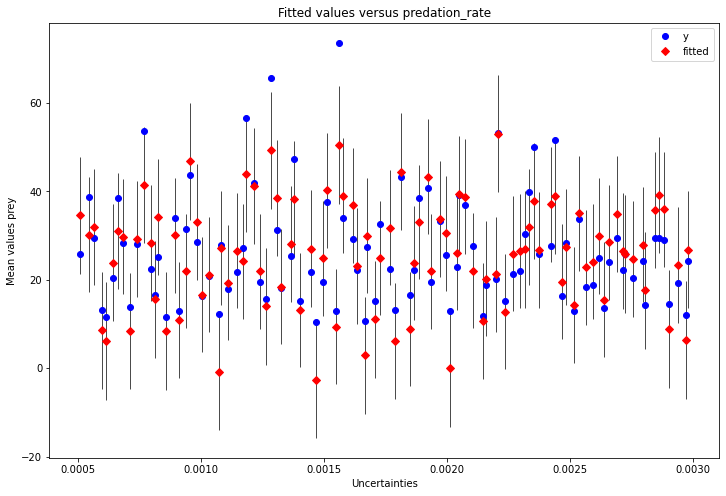

In [15]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_mean, 0, ax=ax)
fig.set_size_inches(12, 8, forward=True)
ax.set_ylabel("Mean values prey")
ax.set_xlabel("Uncertainties")

plt.show()

# Fit a linear regression model for the standard deviations over time

In [16]:
x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_std = sm.OLS(std_outcomes_prey, x)
res_std = reg_mod_std.fit()

print(res_std.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              547.3
Date:                Sun, 09 May 2021   Prob (F-statistic):                    3.90e-65
Time:                        19:50:35   Log-Likelihood:                         -253.16
No. Observations:                 100   AIC:                                      514.3
Df Residuals:                      96   BIC:                                      524.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

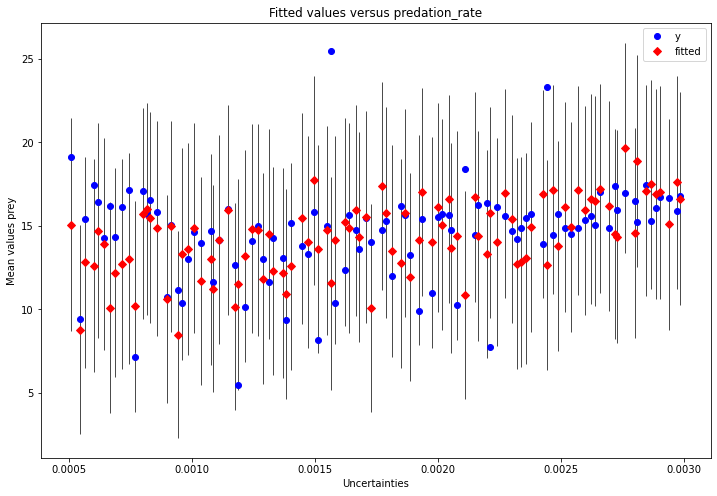

In [17]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_std, 0, ax=ax)
fig.set_size_inches(12, 8, forward=True)
ax.set_ylabel("Mean values prey")
ax.set_xlabel("Uncertainties")

plt.show()

# Part2

### SOBOL sampling

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

# N=50

In [18]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

sa_results = perform_experiments(py_model, scenarios=50, uncertainty_sampling='sobol')
#now we have 50*(2*4+2)=500 scenarios

[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished


In [19]:
experiments, outcomes = sa_results

mean_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean(outcomes['prey'][i]))
mean_outcomes_prey=np.array(mean_outcomes_prey)

std_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(outcomes['prey'][i]))
std_outcomes_prey=np.array(std_outcomes_prey)

problem = get_SALib_problem(py_model.uncertainties)
Si_final = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)
Si_mean = sobol.analyze(problem, mean_outcomes_prey,
                   calc_second_order=True, print_to_console=False)
Si_std = sobol.analyze(problem, std_outcomes_prey,
                   calc_second_order=True, print_to_console=False)


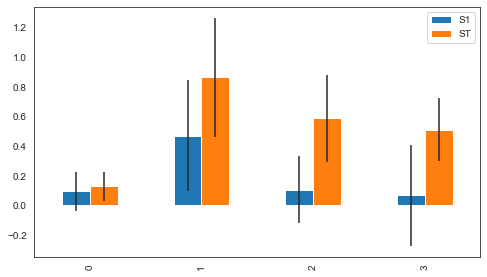

In [20]:
scores_filtered = {k:Si_final[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_finalplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_finalplot[['S1','ST']]
err = Si_finalplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

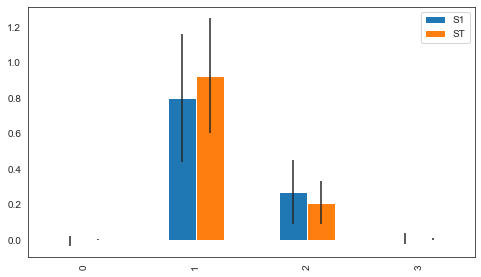

In [21]:
scores_filtered = {k:Si_mean[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_meanplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_meanplot[['S1','ST']]
err = Si_meanplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

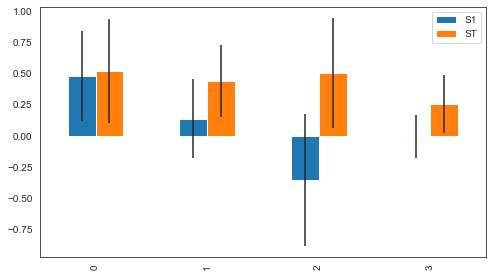

In [22]:
scores_filtered = {k:Si_std[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_stdplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_stdplot[['S1','ST']]
err = Si_stdplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [23]:
print("x1-x2:", Si_final['S2'][0,1], "with confidence interval 95%:", Si_final['S2_conf'][0,1])
print("x1-x3:", Si_final['S2'][0,2], "with confidence interval 95%:", Si_final['S2_conf'][0,2])
print("x1-x4:", Si_final['S2'][0,3], "with confidence interval 95%:", Si_final['S2_conf'][0,3])
print("x2-x3:", Si_final['S2'][1,2], "with confidence interval 95%:", Si_final['S2_conf'][1,2])
print("x2-x4:", Si_final['S2'][1,3], "with confidence interval 95%:", Si_final['S2_conf'][1,3])
print("x3-x4:", Si_final['S2'][2,3], "with confidence interval 95%:", Si_final['S2_conf'][2,3])

x1-x2: -0.05663636424058455 with confidence interval 95%: 0.16425090846606177
x1-x3: -0.09661355423709607 with confidence interval 95%: 0.15480746471861792
x1-x4: -0.16452283134429882 with confidence interval 95%: 0.14619027649177416
x2-x3: -0.08742973544859538 with confidence interval 95%: 0.40133023562100517
x2-x4: -0.017606092674970417 with confidence interval 95%: 0.5151068347087441
x3-x4: 0.06080905318883202 with confidence interval 95%: 0.2989434866869076


# N=250

In [24]:
sa_results = perform_experiments(py_model, scenarios=250, uncertainty_sampling='sobol')
#now we have 1000*(2*4+2)=10000 scenarios

[MainProcess/INFO] performing 2500 scenarios * 1 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


In [25]:
experiments, outcomes = sa_results

mean_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean(outcomes['prey'][i]))
mean_outcomes_prey=np.array(mean_outcomes_prey)

std_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(outcomes['prey'][i]))
std_outcomes_prey=np.array(std_outcomes_prey)

problem = get_SALib_problem(py_model.uncertainties)
Si_final = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)
Si_mean = sobol.analyze(problem, mean_outcomes_prey,
                   calc_second_order=True, print_to_console=False)
Si_std = sobol.analyze(problem, std_outcomes_prey,
                   calc_second_order=True, print_to_console=False)

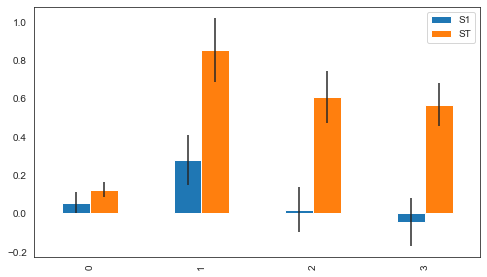

In [26]:
scores_filtered = {k:Si_final[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_finalplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_finalplot[['S1','ST']]
err = Si_finalplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

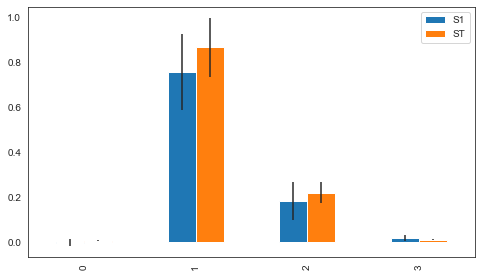

In [27]:
scores_filtered = {k:Si_mean[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_meanplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_meanplot[['S1','ST']]
err = Si_meanplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

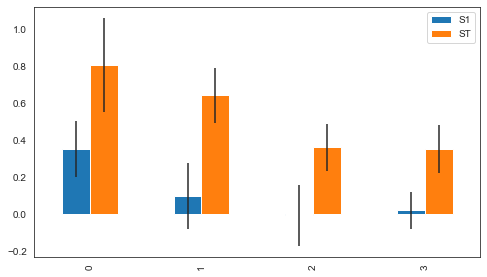

In [28]:
scores_filtered = {k:Si_std[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_stdplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_stdplot[['S1','ST']]
err = Si_stdplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [29]:
print("x1-x2:", Si_final['S2'][0,1], "with confidence interval 95%:", Si_final['S2_conf'][0,1])
print("x1-x3:", Si_final['S2'][0,2], "with confidence interval 95%:", Si_final['S2_conf'][0,2])
print("x1-x4:", Si_final['S2'][0,3], "with confidence interval 95%:", Si_final['S2_conf'][0,3])
print("x2-x3:", Si_final['S2'][1,2], "with confidence interval 95%:", Si_final['S2_conf'][1,2])
print("x2-x4:", Si_final['S2'][1,3], "with confidence interval 95%:", Si_final['S2_conf'][1,3])
print("x3-x4:", Si_final['S2'][2,3], "with confidence interval 95%:", Si_final['S2_conf'][2,3])

x1-x2: -0.01674384923636707 with confidence interval 95%: 0.09799135346039715
x1-x3: -0.03496695214254825 with confidence interval 95%: 0.09026180601159721
x1-x4: -0.058457182221766914 with confidence interval 95%: 0.08676829869690818
x2-x3: 0.06726718522442608 with confidence interval 95%: 0.15612265900543765
x2-x4: 0.09590180927757377 with confidence interval 95%: 0.1760198931730687
x3-x4: 0.16003433494045924 with confidence interval 95%: 0.14154476021189658


# N=1000

In [30]:
sa_results = perform_experiments(py_model, scenarios=1000, uncertainty_sampling='sobol')
#now we have 1000*(2*4+2)=10000 scenarios

[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [31]:
experiments, outcomes = sa_results

mean_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean(outcomes['prey'][i]))
mean_outcomes_prey=np.array(mean_outcomes_prey)

std_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(outcomes['prey'][i]))
std_outcomes_prey=np.array(std_outcomes_prey)

problem = get_SALib_problem(py_model.uncertainties)
Si_final = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)
Si_mean = sobol.analyze(problem, mean_outcomes_prey,
                   calc_second_order=True, print_to_console=False)
Si_std = sobol.analyze(problem, std_outcomes_prey,
                   calc_second_order=True, print_to_console=False)

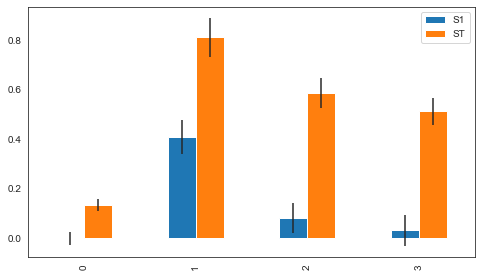

In [32]:
scores_filtered = {k:Si_final[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_finalplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_finalplot[['S1','ST']]
err = Si_finalplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

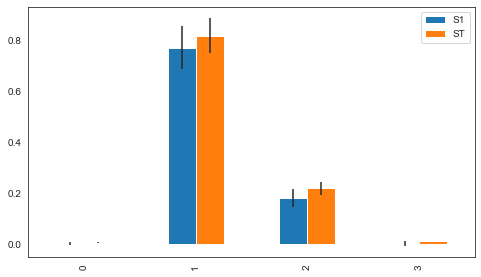

In [33]:
scores_filtered = {k:Si_mean[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_meanplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_meanplot[['S1','ST']]
err = Si_meanplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

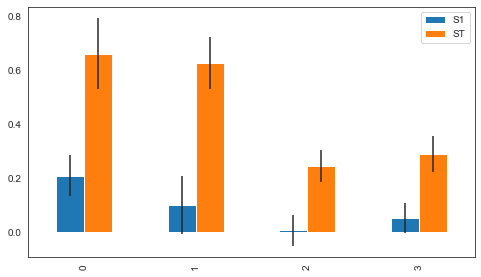

In [34]:
scores_filtered = {k:Si_std[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_stdplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_stdplot[['S1','ST']]
err = Si_stdplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [35]:
print("x1-x2:", Si_final['S2'][0,1], "with confidence interval 95%:", Si_final['S2_conf'][0,1])
print("x1-x3:", Si_final['S2'][0,2], "with confidence interval 95%:", Si_final['S2_conf'][0,2])
print("x1-x4:", Si_final['S2'][0,3], "with confidence interval 95%:", Si_final['S2_conf'][0,3])
print("x2-x3:", Si_final['S2'][1,2], "with confidence interval 95%:", Si_final['S2_conf'][1,2])
print("x2-x4:", Si_final['S2'][1,3], "with confidence interval 95%:", Si_final['S2_conf'][1,3])
print("x3-x4:", Si_final['S2'][2,3], "with confidence interval 95%:", Si_final['S2_conf'][2,3])

x1-x2: 0.009710041117877488 with confidence interval 95%: 0.04971133725705043
x1-x3: 0.0015820596295359063 with confidence interval 95%: 0.044099122747075836
x1-x4: 0.009355983936250544 with confidence interval 95%: 0.04204703691224905
x2-x3: -0.06300859493192545 with confidence interval 95%: 0.09539212996371942
x2-x4: -0.04956582966684217 with confidence interval 95%: 0.10123336210265747
x3-x4: 0.06476259943354126 with confidence interval 95%: 0.08799884710518463


# Si and St

The first-order sensitivity index Si accounts for the contribution of the factor Xi to the output variation.
The total-order sensitivity index STi accounts for all the contributions to the output variation due to factor Xi (i.e. first-order index plus
all its interactions).

# Part 3

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [36]:
keys = ['predators', 'prey']
filtered = dict(zip(keys, [outcomes[k] for k in keys]))

In [37]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = filtered

fs = feature_scoring.get_feature_scores_all(x,y, alg='extra trees', nr_trees=100, max_features=0.6,mode=RuleInductionType.REGRESSION)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


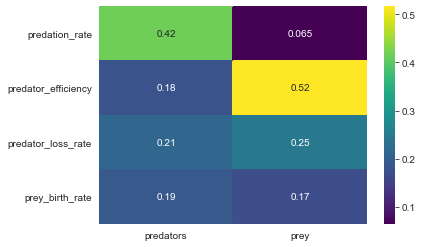

In [38]:
import seaborn as sns
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

In [39]:
fs

,predators,prey
predation_rate,0.416741,0.064882
predator_efficiency,0.181109,0.516366
predator_loss_rate,0.212938,0.247101
prey_birth_rate,0.189211,0.171651


In [40]:
Si_final

{'S1': array([-0.00254622,  0.40766452,  0.07980894,  0.03042556]),
 'S1_conf': array([0.02762441, 0.06963157, 0.06124734, 0.06265183]),
 'ST': array([0.13278521, 0.80937657, 0.58597417, 0.51156524]),
 'ST_conf': array([0.02502345, 0.07843791, 0.06145013, 0.05473078]),
 'S2': array([[        nan,  0.00971004,  0.00158206,  0.00935598],
        [        nan,         nan, -0.06300859, -0.04956583],
        [        nan,         nan,         nan,  0.0647626 ],
        [        nan,         nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.04971134, 0.04409912, 0.04204704],
        [       nan,        nan, 0.09539213, 0.10123336],
        [       nan,        nan,        nan, 0.08799885],
        [       nan,        nan,        nan,        nan]])}

In [41]:
# Check stability
from ema_workbench.analysis import feature_scoring

x = experiments
y = filtered

fs_1 = feature_scoring.get_feature_scores_all(x,y, alg='extra trees', nr_trees=110, max_features=0.8,mode=RuleInductionType.REGRESSION)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


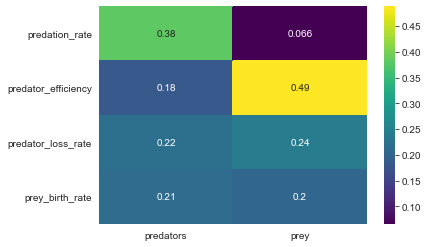

In [44]:
import seaborn as sns
sns.heatmap(fs_1, cmap='viridis', annot=True)
plt.show()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


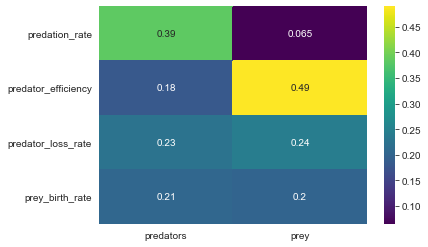

In [46]:
import seaborn as sns
sns.heatmap(fs_1, cmap='viridis', annot=True)
plt.show()

In [47]:
# Check stability
from ema_workbench.analysis import feature_scoring

x = experiments
y = filtered

fs_2 = feature_scoring.get_feature_scores_all(x,y, alg='extra trees', nr_trees=110, max_features=0.6,mode=RuleInductionType.REGRESSION)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


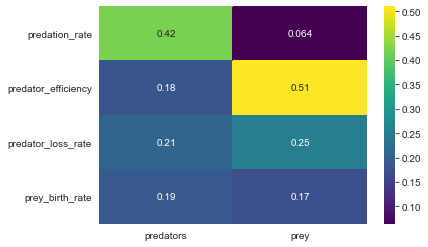

In [48]:
import seaborn as sns
sns.heatmap(fs_1, cmap='viridis', annot=True)
plt.show()

In [51]:
# Check stability
from ema_workbench.analysis import feature_scoring

x = experiments
y = filtered

fs_3  = feature_scoring.get_feature_scores_all(x,y, alg='extra trees', nr_trees=100, max_features=0.8,mode=RuleInductionType.REGRESSION)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


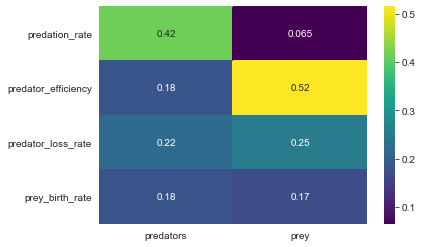

In [50]:
import seaborn as sns
sns.heatmap(fs_3, cmap='viridis', annot=True)
plt.show()

As can be concluded from the analysis above, the estimated importances are not stable yet relative to the input parameters. The prediction error of the importances change whenever the maximum number of features or the number of trees in the forest is increased. This is a typical trade-off between accurancy and time, as an increasing number of trees will be computationaly more heavy but also more accurate.